In [ ]:
%%bash

pip list | grep pydatagen



pydatagen                          0.3.0


In [ ]:
%run nnclassifier.py

In [ ]:
%run doc.py

In [ ]:
td = dfutil.labeled_kv('../datagen/small_id_sample.csv')

In [ ]:
td

,label,key,val
0,0,casenumber,T9VX8PN
1,1,id,IX138774
2,0,phone,29689614910
3,0,casenumber,8WC9D3Z
4,1,id,XA032657
...,...,...,...
295,1,id,JH558491
296,0,phone,2081555
297,0,casenumber,BURO1U
298,1,id,KX098558


In [ ]:
import torch
from torch import nn

dd = DocPipeline()
traindl, validdl = dd.create_training_data(td, 'val', 'label')

model = nn.Sequential(
  nn.Linear(36, 36),
  nn.ReLU(),
  nn.Linear(36, 72),
  nn.Dropout(p=0.2),
  nn.Linear(72, 36),
  nn.Dropout(p=0.2),
  nn.Linear(36, 12),
  nn.ReLU(),
  nn.Linear(12, 1)
)

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

classifier = NNClassifier(model, loss_fn, optimizer)

classifier.set_loaders(traindl, validdl)


In [ ]:
classifier.train(n_epochs=75)

epoch           train_loss      valid_loss      seconds         
0               0.7299          0.7248          0.2684          
1               0.7227          0.7161          0.0059          
2               0.7131          0.7078          0.0058          
3               0.7059          0.7000          0.0057          
4               0.6989          0.6924          0.0056          
5               0.6940          0.6850          0.0056          
6               0.6871          0.6778          0.0055          
7               0.6797          0.6706          0.0057          
8               0.6731          0.6635          0.0056          
9               0.6673          0.6565          0.0058          
10              0.6622          0.6495          0.0054          
11              0.6566          0.6426          0.0055          
12              0.6497          0.6356          0.0055          
13              0.6408          0.6284          0.0056          
14              0.6379   

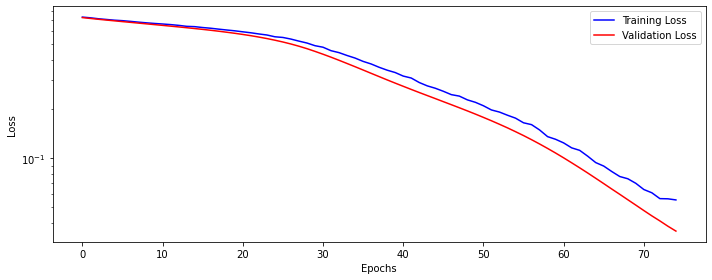

In [ ]:
fig = classifier.plot_losses()

In [ ]:
classifier.save('./models/doc_classifier.model')
dd.save('./models/doc_classifier.pipeline')

In [ ]:
%run doc_wrapper.py

In [ ]:
wrapper = DocWrapper()

In [ ]:
artifacts = {
    'classifier_model_path': './models/doc_classifier.model',
    'classifier_pipeline_path': './models/doc_classifier.pipeline',
}

# this logs the model as an mlflow run
# with mlflow.start_run() as run:
#     mlflow.pyfunc.log_model(
#         artifact_path="mlmodels",
#         python_model=wrapper,
#         code_path=["./code"],
#         artifacts=artifacts
#     )

# this saves the model to the local filesystem
mlflow.pyfunc.save_model(path="./mlflow_local",
                        python_model=wrapper,
                        artifacts=artifacts)


Now reload the model and make some test predictions.

In [ ]:
import pandas as pd

loaded_model = mlflow.pyfunc.load_model("./mlflow_local")

data = [['0', 'name', 'john doe'],
       ['1', 'doc', 'IX138776']]
sample_df = pd.DataFrame(data, columns = ['label', 'key', 'value'])

loaded_model.predict(sample_df)

value
value


,label,key,value,raw,prediction
0,0,name,john doe,-4.683093,0
1,1,doc,IX138776,2.310739,1
